- Author: Peter Steiglechner
- Date: January 2025

> This notebook produces Figure 1 of the manuscript, which illustrates the method/model of opinion perception using fabricated data



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib as mpl
import seaborn as sns
from scipy.optimize import fsolve
import pandas as pd


sns.set_style("ticks", {"axes.linewidth":0.5})

smallfs = 7
bigfs = 9
plt.rc('font', size=smallfs)          # Ticklabels, legend labels, etc.
plt.rc('axes', labelsize=bigfs)    # Axis labels
plt.rc('axes', titlesize=bigfs)    # Titles


In [7]:
def inferSubjectiveLensesAndAxes(df, parties, waves, variables):
    """
    Extract the subjective lenses (matrices containing the scaled and rotated axes) for each partisan identity-group from opinion data in different waves.
    
    Parameters:
        df (pd.DataFrame): Dataframe containing the columns "essround", "identity", and those listed in variables.
        parties (list): List containing the parties.
        waves (list): List of the waves (values in df.essround).
        variables (list): List of the opinion columns.
    
    Returns:
        dict: a transofrmation matrix for each wave and party.
        dict: a matrix containing the subjective bases for each wave and party.
        
    """
    LensTransformation = {}
    subjectiveBases = {}
    
    for r in waves:
        # (1) Lens without considering identites (identity group "None")
        X = df.loc[df.essround == r, variables].dropna(how="any", axis="index").to_numpy()
        eigval, evec = np.linalg.eig(np.cov(X.T))   # returns w, v: column v[:,i] is the eigenvector corresponding to the  eigenvalue w[i]
        LNone = np.array([eigval[ni]**0.5 * evec[:, ni] for ni, i in enumerate(range(np.cov(X.T).shape[0]))]).T
        LNoneinv = np.linalg.inv(LNone)
        LensTransformation[r] = {"None": np.dot(LNoneinv.T, LNoneinv)}
        subjectiveBases[r] = {"None": LNone}

        
        # (2) Lenses for each partisan group
        for p in parties:
            if not (p == "None"):
                X_p = df.loc[(df.essround == r) & (df.identity == p), variables].dropna(how="any", axis="index").to_numpy()
                if not len(X_p) == 0:
                    eigval, evec = np.linalg.eig(np.cov(X_p.T))
                    L_p = np.array([eigval[ni]**0.5 * evec[:, ni] for ni, i in enumerate(range(np.cov(X_p.T).shape[0]))]).T
                    if len(variables) > 1:
                        assert np.dot(L_p[:, 0], L_p[:, 1]) < 1e-13
                    #arrows of the coordinate system [r][p] = L_p
                    L_p_inv = np.linalg.inv(L_p)
                    LensTransformation[r][p] = np.dot(L_p_inv.T, L_p_inv)
                    subjectiveBases[r][p] = L_p
    
    return LensTransformation, subjectiveBases

# Plot the sketch

/usr/lib/python3/dist-packages/matplotlib/patches.py:1570: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center = (self.convert_xunits(self._center[0]),
/usr/lib/python3/dist-packages/matplotlib/patches.py:1571: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.convert_yunits(self._center[1]))
/usr/lib/python3/dist-packages/matplotlib/patches.py:1570: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center = (self.convert_xunits(self.

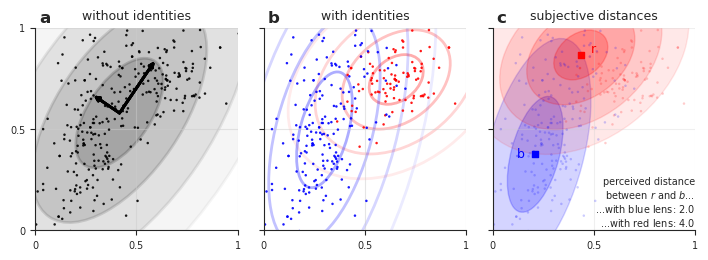

In [11]:

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(17.8/2.54, 6.2/2.54))

np.random.seed(2)
upper_cluster = np.random.random(size=[2,1000]) *0.5 + 0.4
left_cluster = -np.random.random(size=[2,1000]) *0.5 - 0.4
upper_cluster = np.random.multivariate_normal(np.array([0.3,0.5]), 0.6*np.array([[0.1, 0.04], [0.04, 0.1]]), size=2000).T *0.5+ 0.5
left_cluster = np.random.multivariate_normal(-np.array([0.4,0.]), 0.3*np.array([[0.25, 0.2], [0.2, 1.2]]), size=2000).T *0.5+ 0.5

X1_u = upper_cluster[:, np.random.choice(range(2000), 100)]
X1_l = left_cluster[:, np.random.choice(range(2000), 0)]
X2_l = left_cluster[:, np.random.choice(range(2000), 200)]
X1 =np.concatenate([X1_u.T, X1_l.T])
X2 =X2_l.T # np.concatenate([X2_u.T, X2_l.T])
X = np.concatenate([X1, X2])

idsNone = ["black"]*len(X[:, 0])
idsSI =  ["red"]*len(X1[:, 0]) + ["blue"]*len(X2[:, 0])

for ax, ids, data, parties in zip([ax1, ax2, ax3], 
                                  [idsNone, idsSI, idsSI],
                                  [{"black":X}, {"red":X1, "blue":X2}, {"red":X1, "blue":X2}],
                                  [{"None":"black"}, {1:"red", 2:"blue"}, {1:"red", 2:"blue"}]):
    
    df = pd.DataFrame()
    df[["a", "b"]] = X
    df["identity"] = ids
    df["essround"] = 0
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect("equal")
    
    ax.scatter(df["a"], df["b"], edgecolors="none", c=df["identity"], alpha=0.9 if not ax==ax3 else 0.2, s=13, marker=".")

    lenses, subjBases = inferSubjectiveLensesAndAxes(df, parties=parties.values(), waves=[0], variables=["a", "b"])
    for id, p in parties.items():
        T = subjBases[0][p]
        if p=="blue" or p=="black":
            T[:, 1] = -T[:, 1]
        start = np.mean(df.loc[df.identity==p, ["a", "b"]], axis=0)
        angle = np.arctan2(T[:, 0][1], T[:, 0][0]) * 180 / np.pi
        for n in [4,3,2,1]:
            alpha = max(0,0.4-0.08*n) if ax==ax2 else max(0,0.2-0.04*n)
            ellipse = Ellipse(start, n*2*np.linalg.norm(T[:, 0]), n*2*np.linalg.norm(T[:, 1]), angle=angle, edgecolor=p, fc=p if ax!=ax2 else "none", alpha=alpha, lw=2, zorder=0)
            if not ax==ax3:
                ax.add_patch(ellipse)
            if ax == ax1:
                arrowprops = dict(shrinkA=0, shrinkB=0, arrowstyle="<|-", color=p,lw=2, alpha=0.4 if ax==ax3 else 1, edgecolor=None)
                ax.annotate("", start, start+T[:, 1], arrowprops=arrowprops, )
                ax.annotate("", start, start+T[:, 0], arrowprops=arrowprops, )

for ax in [ax1, ax2, ax3]:
    ax.spines["left"].set_position("zero")
    ax.spines["bottom"].set_position("zero")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(alpha=0.3 if ax==ax3 else 0.5)
    ax.set_yticks([0,0.5,1])
    ax.set_xticks([0,0.5,1])
    ax.set_xticklabels([0,0.5,1])
    if ax == ax1:
        ax.set_yticklabels([0,0.5,1])
    else:
        ax.set_yticklabels([])

B = np.array([-0.58, -0.25])*0.5+0.5
p="blue"
_, subjBases = inferSubjectiveLensesAndAxes(df, parties=[p], waves=[0], variables=["a", "b"])
T = subjBases[0][p]
if p=="blue" or p=="black":
    T[:, 1] = -T[:, 1]
    T[:, 0] = -T[:, 0]
arrowprops = dict(shrinkA=0, shrinkB=0, arrowstyle="<|-", color=p,lw=1, alpha=1, edgecolor=None)

angle = np.arctan2(T[:, 0][1], T[:, 0][0]) * 180 / np.pi
for n in [2,1]:
    ellipse = Ellipse(B, n *2* np.linalg.norm(T[:, 0]), n * 2*np.linalg.norm(T[:, 1]), angle=angle, edgecolor=p, fc=p, alpha=max(0,0.25-0.04*n), lw=1, zorder=0)
    ax3.add_patch(ellipse)
        
scale=1
R = np.array([-0.13,0.73])*0.5+0.5

p="red"
_, subjBases = inferSubjectiveLensesAndAxes(df, parties=[p], waves=[0], variables=["a", "b"])
arrowprops["color"] = p
T = subjBases[0][p]


angle = np.arctan2(T[:, 0][1], T[:, 0][0]) * 180 / np.pi
for n in [4,3,2,1]:
    ellipse = Ellipse(R, n*2*np.linalg.norm(T[:, 0]), n*2*np.linalg.norm(T[:, 1]), angle=angle, edgecolor=p, fc=p, alpha=max(0,0.25-0.04*n), lw=1, zorder=0)
    ax3.add_patch(ellipse)

ax3.scatter((B[0],R[0]), (B[1],R[1]), marker="s", c=["b", "r"], s=20 )

ax3.text(B[0]-0.05, B[1], r"b", ha="right", va="center", color="b", fontsize=bigfs)
ax3.text(R[0]+0.05, R[1]+0.03, r"r", ha="left", va="center", color="r", fontsize=bigfs)
delta_b_br = np.dot((B-R).T, np.dot(lenses[0]["blue"], (B-R)))**0.5
delta_r_br = np.dot((B-R).T, np.dot(lenses[0]["red"], (B-R)))**0.5

ax3.text(1, 0.01, r"perceived distance"+"\n"+r"between $r$ and $b$..."+"\n"+rf"...with blue lens: ${delta_b_br:.1f}$" +"\n"+ rf"...with red lens: ${delta_r_br:.1f}$", va="bottom", ha="right", fontsize=smallfs)

ax1.text(0.02, 1.01, "a", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=ax1.transAxes, zorder=20)
ax2.text(0.02, 1.01, "b", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=ax2.transAxes, zorder=20)
ax3.text(0.02, 1.01, "c", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=ax3.transAxes, zorder=20)

ax1.set_title(r"without identities", fontsize=bigfs)
ax2.set_title(r"with identities", fontsize=bigfs)
ax3.set_title(r"subjective distances", fontsize=bigfs)

fig.subplots_adjust(bottom=0.08, left=0.04, right=0.99, top=0.91, hspace=0.05, wspace=0.1)
plt.savefig("figs/polarisedExample_deltaExample_ellipse.pdf")
plt.savefig("figs/polarisedExample_deltaExample_ellipse.png", dpi=600)